In [62]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import ParameterGrid

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import tree
import graphviz

%matplotlib inline

In [2]:
# metrics for each class + weighted average (- bad impact)
# micro f1 = accuracy
def print_metrics(cls, X_test, y_test):
    sns.heatmap(confusion_matrix(y_test, cls.predict(X_test)), annot=True, fmt='g', annot_kws={"size": 16})
    print('accuracy: ',metrics.accuracy_score(y_test, cls.predict(X_test)))
    print()
    print(metrics.classification_report(y_test, cls.predict(X_test)))
    print('macro precision: ',metrics.precision_score(y_test, cls.predict(X_test), average='macro'))
    print('micro precision: ',metrics.precision_score(y_test, cls.predict(X_test), average='micro'))
    print()
    print('micro recall: ',metrics.recall_score(y_test, cls.predict(X_test), average='micro'))
    print('macro recall: ',metrics.recall_score(y_test, cls.predict(X_test), average='macro'))
    print()
    print('micro f1: ',metrics.f1_score(y_test, cls.predict(X_test), average='micro'))
    print('macro f1: ',metrics.f1_score(y_test, cls.predict(X_test), average='macro'))
    plt.show()

# Original data

In [94]:
features = pd.read_csv('data/split/transformed/train_original.csv', index_col=0)
df = pd.read_csv('data/split/transformed/train_original.csv', index_col=0)
features.append(df, ignore_index=True)

features = features[features['ratio_running_duration'] < 25]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(4713, 41)

In [95]:
featuresCV = pd.read_csv('data/split/transformed/cv_original.csv', index_col=0)

featuresCV = featuresCV[featuresCV['ratio_running_duration'] < 25]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(1572, 41)

## Decision Tree

In [5]:
cls = DecisionTreeClassifier

In [6]:
params = {
    'criterion': ['gini', 'entropy'],
    # 'splitter': ['best', 'random'], # je vhodne skusat random?
    'max_depth': range(1, 20),
    'min_samples_split': range(1, 60, 10),
    'min_samples_leaf': range(1, 20, 5),
    #'min_weight_fraction_leaf': ,
    #'max_features': [5, 10, 20, 30, 40],
    'random_state': [64],
    #'max_leaf_nodes': ,
    #'min_impurity_decrease': [0.0],
    'class_weight': [None, 'balanced']
}

In [7]:
len(list(ParameterGrid(params)))

1824

In [8]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [9]:
%%time
gs.fit(features, labels)

Wall time: 3min 22s


GridSearchCV(cv=5, error_score=0,
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 20), 'min_samples_split': range(1, 60, 10), 'min_samples_leaf': range(1, 20, 5), 'random_state': [64], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [10]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:5]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71759, std: 0.01387, params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 11, 'random_state': 64},
 mean: 0.71759, std: 0.01387, params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 21, 'random_state': 64},
 mean: 0.71759, std: 0.01387, params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 31, 'random_state': 64},
 mean: 0.71759, std: 0.01387, params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 41, 'random_state': 64},
 mean: 0.71759, std: 0.01387, params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 51, 'random_state': 64}]

In [11]:
gs.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 16,
 'min_samples_split': 11,
 'random_state': 64}

In [12]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=11,
            min_weight_fraction_leaf=0.0, presort=False, random_state=64,
            splitter='best')

In [14]:
dot_data = tree.export_graphviz(gs.best_estimator_, out_file=None, feature_names=features.columns, class_names=['1','2','3','4'],filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data)
graph.render("tree", view=True)

'tree.pdf'

accuracy:  0.698473282443

             precision    recall  f1-score   support

          1       0.83      0.96      0.89       659
          2       0.39      0.40      0.39       209
          3       0.47      0.38      0.42       336
          4       0.79      0.69      0.74       368

avg / total       0.68      0.70      0.69      1572

macro precision:  0.618463959392
micro precision:  0.698473282443

micro recall:  0.698473282443
macro recall:  0.607146610483

micro f1:  0.698473282443
macro f1:  0.60963857155


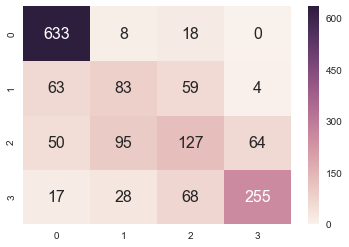

In [15]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

## Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
cls = GradientBoostingClassifier

In [18]:
params = {
    'learning_rate': [0.12, 0.1, 0.08, 0.01], # 0.1
    'n_estimators': [150, 100, 50],
    'max_depth': [1, 2, 3], # 2
    'random_state': [64],
    #'criterion': ['friedman_mse', 'mse'],
    #'min_samples_split': [2, 5, 10, 1.0, 3.0, 5.0, 10.0] # 2
    #'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10] # 1
}

In [19]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [20]:
len(list(ParameterGrid(params)))

36

In [21]:
%%time
gs.fit(features, labels)

Wall time: 3min 21s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [22]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.73329, std: 0.01331, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 50},
 mean: 0.73074, std: 0.01152, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 100},
 mean: 0.73032, std: 0.01210, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
 mean: 0.73011, std: 0.00966, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 150},
 mean: 0.72968, std: 0.00783, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
 mean: 0.72968, std: 0.01110, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100},
 mean: 0.72947, std: 0.01012, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 50},
 mean: 0.72926, std: 0.01228, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 150},
 mean: 0.72905, std: 0.01126, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 50},
 mean: 0.72841, std: 0.01040, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150},
 mean: 

accuracy:  0.730916030534

             precision    recall  f1-score   support

          1       0.84      0.97      0.90       659
          2       0.46      0.31      0.37       209
          3       0.53      0.54      0.54       336
          4       0.80      0.71      0.75       368

avg / total       0.71      0.73      0.72      1572

macro precision:  0.657640945069
micro precision:  0.730916030534

micro recall:  0.730916030534
macro recall:  0.633432278107

micro f1:  0.730916030534
macro f1:  0.639919840223


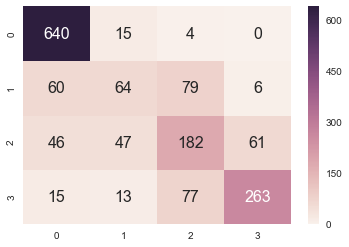

In [23]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

### Try balanced class

In [24]:
from sklearn.utils import class_weight
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [25]:
%%time
gs.fit(features, labels, sample_weight=labels_weights)

Wall time: 3min 19s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [26]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71780, std: 0.00550, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 150},
 mean: 0.71717, std: 0.00955, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 150},
 mean: 0.71717, std: 0.01376, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 100},
 mean: 0.71695, std: 0.00887, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150},
 mean: 0.71674, std: 0.00940, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 50},
 mean: 0.71632, std: 0.01043, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
 mean: 0.71568, std: 0.01355, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 150},
 mean: 0.71504, std: 0.01239, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 50},
 mean: 0.71504, std: 0.00611, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150},
 mean: 0.71462, std: 0.01154, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100},
 mean

accuracy:  0.712468193384

             precision    recall  f1-score   support

          1       0.89      0.90      0.90       659
          2       0.36      0.49      0.42       209
          3       0.56      0.46      0.51       336
          4       0.78      0.73      0.75       368

avg / total       0.72      0.71      0.72      1572

macro precision:  0.64855132786
micro precision:  0.712468193384

micro recall:  0.712468193384
macro recall:  0.64527509627

micro f1:  0.712468193384
macro f1:  0.642620948091


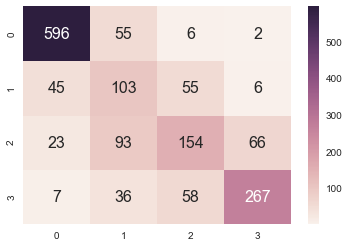

In [27]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

## KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
cls = KNeighborsClassifier

In [30]:
params = {
    'n_neighbors': [5, 10, 20, 50, 100, 200, 500, 1000],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [31]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [32]:
len(list(ParameterGrid(params)))

64

In [33]:
%%time
gs.fit(features, labels)

Wall time: 2min 9s


GridSearchCV(cv=5, error_score=0,
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [5, 10, 20, 50, 100, 200, 500, 1000], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [34]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.68364, std: 0.00975, params: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'},
 mean: 0.68364, std: 0.01193, params: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'},
 mean: 0.68364, std: 0.00975, params: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'uniform'},
 mean: 0.68364, std: 0.01193, params: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'},
 mean: 0.68364, std: 0.00975, params: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'weights': 'uniform'},
 mean: 0.68364, std: 0.01193, params: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'weights': 'distance'},
 mean: 0.68364, std: 0.00975, params: {'algorithm': 'brute', 'n_neighbors': 20, 'weights': 'uniform'},
 mean: 0.68364, std: 0.01193, params: {'algorithm': 'brute', 'n_neighbors': 20, 'weights': 'distance'},
 mean: 0.67982, std: 0.01154, params: {'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'distance'},
 mean: 0.67982, std: 0.01154, params: {'algorithm': 'ball_t

accuracy:  0.686386768448

             precision    recall  f1-score   support

          1       0.76      0.98      0.85       659
          2       0.35      0.17      0.23       209
          3       0.51      0.48      0.49       336
          4       0.79      0.65      0.71       368

avg / total       0.66      0.69      0.66      1572

macro precision:  0.601027829178
micro precision:  0.686386768448

micro recall:  0.686386768448
macro recall:  0.568696070697

micro f1:  0.686386768448
macro f1:  0.571523126232


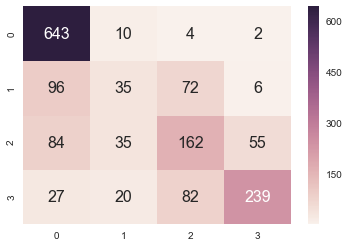

In [35]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

# Transformed features (Robust Scaler + Box-Cox)

In [63]:
features = pd.read_csv('data/split/transformed/train.csv', index_col=0)
df = pd.read_csv('data/split/transformed/train.csv', index_col=0)
features.append(df, ignore_index=True)

features = features[features['ratio_running_duration_original'] < 25]
features.drop('ratio_running_duration_original', axis=1, inplace=True)

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(4713, 41)

In [64]:
featuresCV = pd.read_csv('data/split/transformed/cv.csv', index_col=0)

featuresCV = featuresCV[featuresCV['ratio_running_duration_original'] < 25]
featuresCV.drop('ratio_running_duration_original', axis=1, inplace=True)

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(1572, 41)

## LogisticRegression

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
cls = LogisticRegression

In [44]:
params = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': ['balanced', None],
    'random_state': [64],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'multi_class': ['ovr', 'multinomial'],
    'max_iter': [10, 50, 100, 200, 500]
}

In [45]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [46]:
len(list(ParameterGrid(params)))

240

In [47]:
%%time
gs.fit(features, labels)

Wall time: 11min 5s


C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score=0,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 10.0], 'class_weight': ['balanced', None], 'random_state': [64], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class': ['ovr', 'multinomial'], 'max_iter': [10, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [48]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.72035, std: 0.01689, params: {'C': 10.0, 'class_weight': None, 'max_iter': 10, 'multi_class': 'multinomial', 'random_state': 64, 'solver': 'newton-cg'},
 mean: 0.71886, std: 0.01345, params: {'C': 10.0, 'class_weight': None, 'max_iter': 500, 'multi_class': 'multinomial', 'random_state': 64, 'solver': 'sag'},
 mean: 0.71801, std: 0.01086, params: {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'multi_class': 'multinomial', 'random_state': 64, 'solver': 'lbfgs'},
 mean: 0.71801, std: 0.01513, params: {'C': 10.0, 'class_weight': None, 'max_iter': 500, 'multi_class': 'multinomial', 'random_state': 64, 'solver': 'lbfgs'},
 mean: 0.71780, std: 0.00902, params: {'C': 1.0, 'class_weight': None, 'max_iter': 10, 'multi_class': 'multinomial', 'random_state': 64, 'solver': 'newton-cg'},
 mean: 0.71780, std: 0.01067, params: {'C': 1.0, 'class_weight': None, 'max_iter': 50, 'multi_class': 'multinomial', 'random_state': 64, 'solver': 'newton-cg'},
 mean: 0.71780, std: 0.01067, params: {'C'

accuracy:  0.712468193384

             precision    recall  f1-score   support

          1       0.84      0.95      0.89       659
          2       0.36      0.21      0.26       209
          3       0.51      0.53      0.52       336
          4       0.76      0.74      0.75       368

avg / total       0.69      0.71      0.70      1572

macro precision:  0.617343479219
micro precision:  0.712468193384

micro recall:  0.712468193384
macro recall:  0.607483541381

micro f1:  0.712468193384
macro f1:  0.606594261725


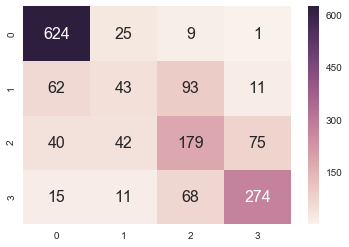

In [49]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

## LDA

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [59]:
cls = LinearDiscriminantAnalysis

In [60]:
params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.0001, 0.001, 0.01],
    'tol': [1e-4, 1e-3, 1e-1, 1e-10]
}

In [61]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)
len(list(ParameterGrid(params)))

60

In [62]:
%%time
gs.fit(features, labels)

Wall time: 9.11 s


C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


GridSearchCV(cv=5, error_score=0,
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.0001, 0.001, 0.01], 'tol': [0.0001, 0.001, 0.1, 1e-10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [65]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.70762, std: 0.01020, params: {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 0.0001},
 mean: 0.70762, std: 0.01020, params: {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 0.001},
 mean: 0.70762, std: 0.01020, params: {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 0.1},
 mean: 0.70762, std: 0.01020, params: {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 1e-10},
 mean: 0.70741, std: 0.01312, params: {'shrinkage': 0.001, 'solver': 'lsqr', 'tol': 0.0001},
 mean: 0.70741, std: 0.01312, params: {'shrinkage': 0.001, 'solver': 'lsqr', 'tol': 0.001},
 mean: 0.70741, std: 0.01312, params: {'shrinkage': 0.001, 'solver': 'lsqr', 'tol': 0.1},
 mean: 0.70741, std: 0.01312, params: {'shrinkage': 0.001, 'solver': 'lsqr', 'tol': 1e-10},
 mean: 0.70719, std: 0.01283, params: {'shrinkage': 0.01, 'solver': 'lsqr', 'tol': 0.0001},
 mean: 0.70719, std: 0.01283, params: {'shrinkage': 0.01, 'solver': 'lsqr', 'tol': 0.001}]

accuracy:  0.693384223919

             precision    recall  f1-score   support

          1       0.85      0.91      0.88       659
          2       0.35      0.34      0.34       209
          3       0.49      0.46      0.47       336
          4       0.76      0.71      0.73       368

avg / total       0.69      0.69      0.69      1572

macro precision:  0.612515707991
micro precision:  0.693384223919

micro recall:  0.693384223919
macro recall:  0.60698575377

micro f1:  0.693384223919
macro f1:  0.609248649394


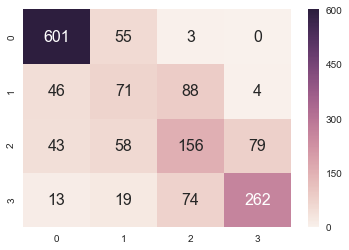

In [64]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

# LinearSVC

In [36]:
from sklearn.svm import LinearSVC

In [67]:
cls = LinearSVC

In [68]:
params = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    #'tol': [1e-4, 1e-3, 1e-1, 1e-10],
    'C': [0.5, 1, 10, 20, 50], 
    'multi_class': ['crammer_singer', 'ovr'],
    'class_weight': [None, 'balanced'],
    'max_iter': [10, 100, 1000, 10000]
}

In [69]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)
len(list(ParameterGrid(params)))

320

In [70]:
%%time
gs.fit(features, labels)

Wall time: 3h 22min 20s


GridSearchCV(cv=5, error_score=0,
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'], 'C': [0.5, 1, 10, 20, 50], 'multi_class': ['crammer_singer', 'ovr'], 'class_weight': [None, 'balanced'], 'max_iter': [10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [71]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71865, std: 0.00890, params: {'C': 20, 'class_weight': None, 'loss': 'hinge', 'max_iter': 100, 'multi_class': 'crammer_singer', 'penalty': 'l2'},
 mean: 0.71823, std: 0.00982, params: {'C': 20, 'class_weight': None, 'loss': 'hinge', 'max_iter': 100, 'multi_class': 'crammer_singer', 'penalty': 'l1'},
 mean: 0.71738, std: 0.01051, params: {'C': 20, 'class_weight': None, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'crammer_singer', 'penalty': 'l2'},
 mean: 0.71717, std: 0.00985, params: {'C': 20, 'class_weight': None, 'loss': 'hinge', 'max_iter': 10000, 'multi_class': 'crammer_singer', 'penalty': 'l1'},
 mean: 0.71695, std: 0.01254, params: {'C': 50, 'class_weight': None, 'loss': 'squared_hinge', 'max_iter': 10000, 'multi_class': 'crammer_singer', 'penalty': 'l1'},
 mean: 0.71632, std: 0.00745, params: {'C': 20, 'class_weight': None, 'loss': 'squared_hinge', 'max_iter': 100, 'multi_class': 'crammer_singer', 'penalty': 'l1'},
 mean: 0.71610, std: 0.00644, params: {'C

In [38]:
cls = LinearSVC(C=20, class_weight=None, loss='hinge', max_iter=100, multi_class='crammer_singer', penalty='l2')
cls.fit(features, labels)

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=100,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

accuracy:  0.712468193384

             precision    recall  f1-score   support

          1       0.84      0.94      0.89       659
          2       0.41      0.22      0.28       209
          3       0.50      0.53      0.52       336
          4       0.75      0.75      0.75       368

avg / total       0.69      0.71      0.70      1572

macro precision:  0.62554708358
micro precision:  0.712468193384

micro recall:  0.712468193384
macro recall:  0.609652431055

micro f1:  0.712468193384
macro f1:  0.609256455945


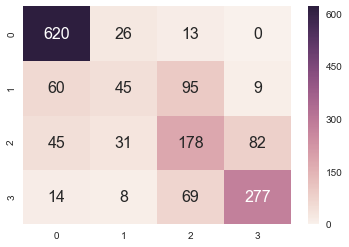

In [39]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

# MLP

In [25]:
from sklearn.neural_network import MLPClassifier

In [26]:
cls = MLPClassifier

In [27]:
params = {
    'hidden_layer_sizes': [(100,), (50,), (200,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.00001, 0.001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 300],
}

In [28]:
gs = GridSearchCV(cls(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)
len(list(ParameterGrid(params)))

972

In [29]:
%%time
gs.fit(features, labels)

Wall time: 1h 51min 31s


GridSearchCV(cv=5, error_score=0,
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(100,), (50,), (200,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0001, 1e-05, 0.001], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [30]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.72586, std: 0.01635, params: {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'},
 mean: 0.72438, std: 0.01408, params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'max_iter': 300, 'solver': 'lbfgs'},
 mean: 0.72417, std: 0.01712, params: {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 300, 'solver': 'lbfgs'},
 mean: 0.72417, std: 0.01305, params: {'activation': 'identity', 'alpha': 1e-05, 'hidden_layer_sizes': (200,), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'lbfgs'},
 mean: 0.72417, std: 0.01683, params: {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'lbfgs'},
 mean: 0.72374, std: 0.01408, params: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (200,), 'learning_

accuracy:  0.712468193384

             precision    recall  f1-score   support

          1       0.84      0.94      0.89       659
          2       0.41      0.22      0.28       209
          3       0.50      0.53      0.52       336
          4       0.75      0.75      0.75       368

avg / total       0.69      0.71      0.70      1572

macro precision:  0.62554708358
micro precision:  0.712468193384

micro recall:  0.712468193384
macro recall:  0.609652431055

micro f1:  0.712468193384
macro f1:  0.609256455945


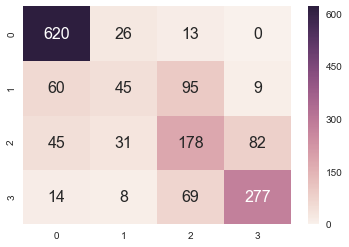

In [31]:
print_metrics(gs.best_estimator_, featuresCV, labelsCV)

# NO HP TUNING

# Lr CV

accuracy:  0.730744748568

             precision    recall  f1-score   support

          1       0.85      0.96      0.90      1962
          2       0.53      0.27      0.36       630
          3       0.54      0.57      0.56      1060
          4       0.75      0.74      0.74      1061

avg / total       0.71      0.73      0.72      4713

macro precision:  0.666846797097
micro precision:  0.730744748568

micro recall:  0.730744748568
macro recall:  0.635394249442

micro f1:  0.730744748568
macro f1:  0.63947210539


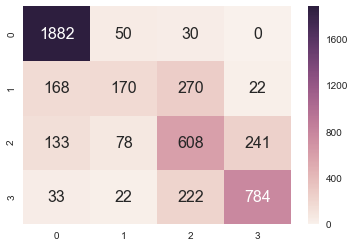

In [65]:
from sklearn.linear_model import LogisticRegressionCV
cls = LogisticRegressionCV(multi_class='multinomial')
cls.fit(features, labels)
print_metrics(cls, features, labels)

accuracy:  0.722646310433

             precision    recall  f1-score   support

          1       0.85      0.95      0.90       659
          2       0.43      0.24      0.31       209
          3       0.51      0.54      0.53       336
          4       0.75      0.75      0.75       368

avg / total       0.70      0.72      0.71      1572

macro precision:  0.638231382623
micro precision:  0.722646310433

micro recall:  0.722646310433
macro recall:  0.620900336522

micro f1:  0.722646310433
macro f1:  0.621714813519


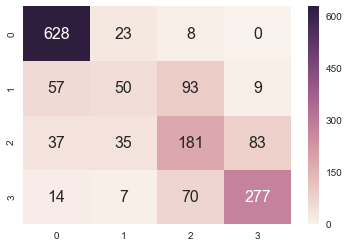

In [66]:
print_metrics(cls, featuresCV, labelsCV)

# GBC

accuracy:  0.824527901549

             precision    recall  f1-score   support

          1       0.89      0.98      0.93      1962
          2       0.73      0.55      0.63       630
          3       0.70      0.74      0.72      1060
          4       0.87      0.79      0.83      1061

avg / total       0.82      0.82      0.82      4713

macro precision:  0.798005287973
micro precision:  0.824527901549

micro recall:  0.824527901549
macro recall:  0.764377907318

micro f1:  0.824527901549
macro f1:  0.776881431491


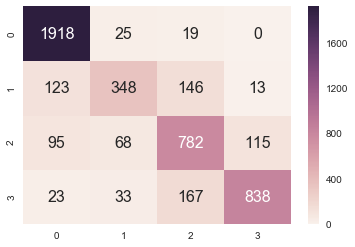

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
cls = GradientBoostingClassifier(random_state=64)
cls.fit(features, labels)
print_metrics(cls, features, labels)

accuracy:  0.727735368957

             precision    recall  f1-score   support

          1       0.85      0.96      0.90       659
          2       0.42      0.31      0.35       209
          3       0.54      0.54      0.54       336
          4       0.79      0.73      0.76       368

avg / total       0.71      0.73      0.72      1572

macro precision:  0.647743523978
micro precision:  0.727735368957

micro recall:  0.727735368957
macro recall:  0.632905990945

micro f1:  0.727735368957
macro f1:  0.637278147535


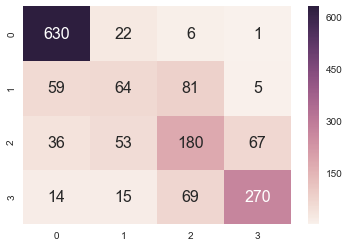

In [34]:
print_metrics(cls, featuresCV, labelsCV)

In [35]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
10,ratio_pledged_goal,0.260361
13,usd_goal,0.073220
0,average_pledge,0.052129
4,days_preparation,0.044212
11,ratio_running_duration,0.043160
34,image_count,0.042164
2,category_position,0.040727
9,pledged,0.039319
14,usd_pledged,0.036183
1,backers_count,0.029698


# adding tf-idf

In [49]:
text = pd.read_csv('data/split/nlp/train_tfidf.csv', index_col=0, encoding='latin1')
text2 = pd.read_csv('data/split/nlp/test_tfidf.csv', index_col=0, encoding='latin1')

text.append(text2, ignore_index=True)

text = text[text['ratio_running_duration'] < 25]

text.iloc[:,61:].columns

Index(['tf-idf', 'token_taken', 'token_iphone', 'token_folk', 'token_thank',
       'token_much', 'token_time', 'token_added', 'token_photo', 'token_year',
       ...
       'token_freunden', 'token_skater', 'token_kickstater', 'token_kontakt',
       'token_bisexual', 'token_disruption', 'token_dump', 'token_edison',
       'token_volcano', 'token_so'],
      dtype='object', length=14412)

In [50]:
features = pd.concat([features, text.iloc[:,62:]], axis=1)

In [51]:
text = pd.read_csv('data/split/nlp/cv_tfidf.csv', index_col=0, encoding='latin1')

text = text[text['ratio_running_duration'] < 25]

text.iloc[:,57:].columns

Index(['tf-idf', 'token_taken', 'token_iphone', 'token_folk', 'token_thank',
       'token_much', 'token_time', 'token_added', 'token_photo', 'token_year',
       ...
       'token_freunden', 'token_skater', 'token_kickstater', 'token_kontakt',
       'token_bisexual', 'token_disruption', 'token_dump', 'token_edison',
       'token_volcano', 'token_so'],
      dtype='object', length=14412)

In [52]:
featuresCV = pd.concat([featuresCV, text.iloc[:,58:]], axis=1)

In [53]:
features.shape

(4713, 14452)

In [54]:
featuresCV.shape

(1572, 14452)

In [126]:
from sklearn.utils import class_weight
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [55]:
cls = GradientBoostingClassifier(random_state=64)
cls.fit(features, labels) # , sample_weight=labels_weights

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.733460559796

             precision    recall  f1-score   support

          1       0.85      0.97      0.91       659
          2       0.45      0.35      0.39       209
          3       0.55      0.54      0.54       336
          4       0.79      0.70      0.75       368

avg / total       0.72      0.73      0.72      1572

macro precision:  0.660722684141
micro precision:  0.733460559796

micro recall:  0.733460559796
macro recall:  0.640371704475

micro f1:  0.733460559796
macro f1:  0.647088184929


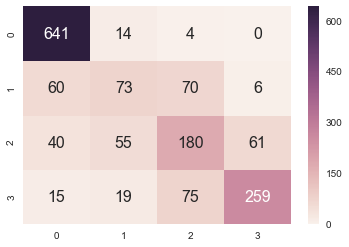

In [56]:
print_metrics(cls, featuresCV, labelsCV)

In [57]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
10,ratio_pledged_goal,0.165101
13,usd_goal,0.019041
11,ratio_running_duration,0.016352
6,days_running,0.007598
1,backers_count,0.007496
34,image_count,0.006301
1186,token_performance,0.005950
368,token_stretch,0.004866
9,pledged,0.004790
2,category_position,0.004659


# adding LSA

In [67]:
text = pd.read_csv('data/split/nlp/min_max_df/train_lsa.csv', index_col=0, encoding='latin1')
text2 = pd.read_csv('data/split/nlp/min_max_df/test_lsa.csv', index_col=0, encoding='latin1')

text.append(text2, ignore_index=True)

text = text[text['ratio_running_duration'] < 25]

text.iloc[:,:].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       'ratio_running_duration'],
      dtype='object')

In [68]:
features = pd.concat([features, text.iloc[:,:-1]], axis=1)

In [69]:
text = pd.read_csv('data/split/nlp/min_max_df/cv_lsa.csv', index_col=0, encoding='latin1')

text = text[text['ratio_running_duration'] < 25]

text.iloc[:,:].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       'ratio_running_duration'],
      dtype='object')

In [70]:
featuresCV = pd.concat([featuresCV, text.iloc[:,:-1]], axis=1)

In [14]:
features.shape

(4713, 66)

In [15]:
featuresCV.shape

(1572, 66)

from sklearn.utils import class_weight
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
cls = GradientBoostingClassifier(random_state=64)
cls.fit(features, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.74427480916

             precision    recall  f1-score   support

          1       0.86      0.97      0.91       659
          2       0.52      0.39      0.45       209
          3       0.56      0.56      0.56       336
          4       0.78      0.71      0.75       368

avg / total       0.73      0.74      0.73      1572

macro precision:  0.680766335392
micro precision:  0.74427480916

micro recall:  0.74427480916
macro recall:  0.658354276081

micro f1:  0.74427480916
macro f1:  0.666004639308


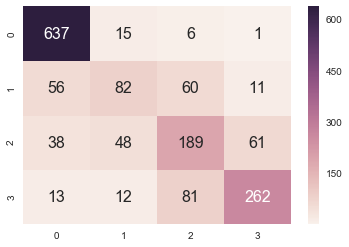

In [17]:
print_metrics(cls, featuresCV, labelsCV)

In [78]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
10,ratio_pledged_goal,0.230152
13,usd_goal,0.040467
9,pledged,0.031140
11,ratio_running_duration,0.029371
50,9,0.025234
43,2,0.025202
42,1,0.024283
47,6,0.023803
52,11,0.023683
57,16,0.021945


# adding LDA

In [96]:
text = pd.read_csv('data/split/nlp/train_lda25.csv', index_col=0, encoding='latin1')
text2 = pd.read_csv('data/split/nlp/test_lda25.csv', index_col=0, encoding='latin1')

text.append(text2, ignore_index=True)

text = text[text['ratio_running_duration'] < 25]

text.iloc[:,:].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       'ratio_running_duration'],
      dtype='object')

In [97]:
features = pd.concat([features, text.iloc[:,:-1]], axis=1)

In [98]:
text = pd.read_csv('data/split/nlp/cv_lda25.csv', index_col=0, encoding='latin1')

text = text[text['ratio_running_duration'] < 25]

text.iloc[:,:].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       'ratio_running_duration'],
      dtype='object')

In [99]:
featuresCV = pd.concat([featuresCV, text.iloc[:,:-1]], axis=1)

In [100]:
features.shape

(4713, 66)

In [101]:
featuresCV.shape

(1572, 66)

from sklearn.utils import class_weight
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [102]:
from sklearn.ensemble import GradientBoostingClassifier
cls = GradientBoostingClassifier(random_state=64)
cls.fit(features, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.858052196053

             precision    recall  f1-score   support

          1       0.90      0.98      0.94      1962
          2       0.80      0.65      0.71       630
          3       0.77      0.79      0.78      1060
          4       0.89      0.82      0.86      1061

avg / total       0.86      0.86      0.85      4713

macro precision:  0.840208767013
micro precision:  0.858052196053

micro recall:  0.858052196053
macro recall:  0.809830523225

micro f1:  0.858052196053
macro f1:  0.822239724936


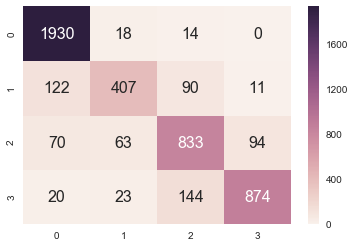

In [103]:
print_metrics(cls, features, labels)

accuracy:  0.740458015267

             precision    recall  f1-score   support

          1       0.84      0.95      0.89       659
          2       0.48      0.38      0.43       209
          3       0.58      0.57      0.58       336
          4       0.80      0.72      0.76       368

avg / total       0.73      0.74      0.73      1572

macro precision:  0.675572224152
micro precision:  0.740458015267

micro recall:  0.740458015267
macro recall:  0.656373791419

micro f1:  0.740458015267
macro f1:  0.663333650994


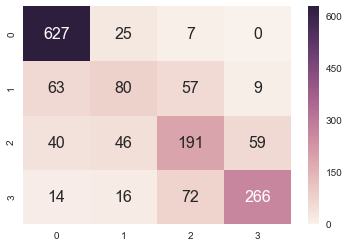

In [104]:
print_metrics(cls, featuresCV, labelsCV)

In [105]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance
    
importances.sort_values(by='importance', ascending=False)

,feature,importance
10,ratio_pledged_goal,0.214611
13,usd_goal,0.037574
42,1,0.035786
11,ratio_running_duration,0.028478
0,average_pledge,0.027398
55,14,0.026260
51,10,0.024977
62,21,0.024255
50,9,0.022190
49,8,0.021532
